In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, top_k_accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F

from torchvision import transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision.transforms.functional import InterpolationMode
from imutils import paths
from PIL import Image

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Create outputs folder
dir = "/content/drive/MyDrive/SHBT261/Project/"
save_dir = os.path.join(dir, "outputs/vit_results")
os.makedirs(save_dir, exist_ok=True)

In [3]:
# Load image and preprocess
img_dir = os.path.join(dir, "dataset/caltech-101")
image_paths = list(paths.list_images(img_dir))

data, labels = [], []

for img_path in tqdm(image_paths):
    label = img_path.split(os.path.sep)[-2]
    if label == "BACKGROUND_Google":  # remove this class
        continue
    labels.append(label)
    data.append(img_path)

# Encode labels
lb = LabelEncoder()
labels = lb.fit_transform(labels)

print(f"Total Number of Classes: {len(lb.classes_)}")

100%|██████████| 9144/9144 [00:00<00:00, 1211967.63it/s]

Total Number of Classes: 101


#### Load data and processing

In [4]:
# Load image and preprocess
img_dir = os.path.join(dir, "dataset/caltech-101")
image_paths = list(paths.list_images(img_dir))

data, labels = [], []

for img_path in tqdm(image_paths):
    label = img_path.split(os.path.sep)[-2]
    if label == "BACKGROUND_Google":  # remove this class
        continue
    labels.append(label)
    data.append(img_path)

# Encode labels
lb = LabelEncoder()
labels = lb.fit_transform(labels)

print(f"Total Number of Classes: {len(lb.classes_)}")

100%|██████████| 9144/9144 [00:00<00:00, 1180628.47it/s]

Total Number of Classes: 101


In [5]:
# Define custom dataset
class CaltechDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

#### Split dataset and transform|

In [6]:
# Hyperparameters and DataLoaders
image_size = 128        # 128 or 64
optimizer_name = "adam"  # "adam" or "sgd"
learning_rate = 1e-4
batch_size = 32
num_epochs = 30
patience = 5
weight_decay=1e-4

# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Stratified split 70/15/15
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    data, labels, test_size=0.30, stratify=labels, random_state=seed
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.50, stratify=temp_labels, random_state=seed
)

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

train_dataset = CaltechDataset(train_paths, train_labels, train_transform)
val_dataset = CaltechDataset(val_paths, val_labels, val_transform)
test_dataset = CaltechDataset(test_paths, test_labels, val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train: 6073, Val: 1302, Test: 1302


#### Model

ViT uses fixed-size images (e.g., 224×224) during training, which generates a fixed number of patches (e.g., 14×14 patches), so the positional encodings are also fixed-length.

However, we now use 128×128 images, the number of patches will change, for example, from 14×14 to 8×8. Therefore, the positional encodings must be interpolated; otherwise, the dimensions will not match and the model will fail.

| 参数                 | 数值                                  |
| ------------------ | ----------------------------------- |
| Patch size         | 16×16                               |
| Image size         | 224×224（默认）                         |
| Patch 数量           | ( (224/16)^2 = 14 \times 14 = 196 ) |
| Embedding dim      | 768                                 |
| Transformer layers | 12                                  |
| Attention heads    | 12                                  |
| MLP size           | 3072                                |
| [CLS] token        | 有                                   |
| 分类头                | Linear(768, num_classes)            |


| 模块                             | 标准 ViT                     | 你当前设置                                       | 说明                                                   |
| ------------------------------ | -------------------------- | ------------------------------------------- | ---------------------------------------------------- |
| **输入图像大小**                     | `224×224×3`                | `128×128×3` 或 `64×64×3`                     | ✅ 你缩小了输入图像尺寸以减少计算和内存开销                               |
| **Patch 数量**                   | (14×14 = 196)              | `128//16 = 8×8 = 64`<br>`64//16 = 4×4 = 16` | ✅ 图像越小，patch 越少 → 位置编码长度变短                           |
| **位置编码（Positional Embedding）** | `[1, 197, 768]`            | `[1, 65, 768]` 或 `[1, 17, 768]`             | ✅ 你调用 `resize_positional_encoding` 对位置编码进行插值，适配较小输入  |
| **Transformer 层是否训练**          | 默认全部训练                     | 只解冻最后两层 encoder block                       | ✅ 你选择只 fine-tune `model.encoder.layers[-2:]`，降低过拟合风险 |
| **分类头**                        | `[768] → [1000]`（ImageNet） | `[768] → [101]`（Caltech-101）                | ✅ 你替换了 `model.heads.head`，适配你自己的分类任务                 |


        Input Image (64x64 or 128x128)
                   ↓
         Patch Embedding (16x16 patch)          ← 🟡 输入图像变小，patch 变少
                   ↓
     Flattened patches → Patch Tokens (16 or 64)
                   ↓
     + Positional Embedding (resized)           ← 🟡 调用了 interpolate 处理位置编码
                   ↓
         [CLS] token is prepended
                   ↓
    ↓↓↓↓↓ Transformer Encoder ↓↓↓↓↓
    │   Layer 1 (Frozen)                        ← 🔒 冻结
    │   Layer 2 (Frozen)                        ← 🔒 冻结
    │   ...
    │   Layer 11 (Trainable)                    ← ✅ 解冻
    │   Layer 12 (Trainable)                    ← ✅ 解冻
    ↓
         [CLS] token output
                   ↓
       Classification Head: Linear(768 → 101)  ← ✅ 替换成你任务需要的头


In [7]:
def resize_positional_encoding(model, new_img_size=128):
    # Get old patch grid size
    num_patches_old = model.encoder.pos_embedding.shape[1] - 1  # exclude cls token
    old_size = int(num_patches_old ** 0.5)

    # Compute new patch grid size
    patch_size = model.patch_size  # 16
    new_size = new_img_size // patch_size  # 8 if img=128

    # Separate class and patch embeddings
    cls_pos_embed = model.encoder.pos_embedding[:, 0:1, :]
    patch_pos_embed = model.encoder.pos_embedding[:, 1:, :]
    patch_pos_embed = patch_pos_embed.reshape(1, old_size, old_size, -1).permute(0, 3, 1, 2)

    # Bilinear interpolate patch embeddings
    patch_pos_embed = F.interpolate(patch_pos_embed, size=(new_size, new_size),
                                    mode='bilinear', align_corners=False)
    patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).reshape(1, new_size * new_size, -1)

    # Concatenate cls token embedding
    new_pos_embed = torch.cat([cls_pos_embed, patch_pos_embed], dim=1)
    model.encoder.pos_embedding = nn.Parameter(new_pos_embed)


def get_vit_b16(num_classes, img_size=128, fine_tune_blocks=2):
    # Load pretrained ViT-B/16
    model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)

    # Disable input size check (torchvision enforces 224×224)
    model._process_input = lambda x: x

    # Resize positional embeddings
    resize_positional_encoding(model, new_img_size=img_size)

    # Custom forward (replace missing cls_token from encoder)
    def forward_fixed(self, x):
        B = x.shape[0]
        x = self.conv_proj(x)  # [B, C, H/patch, W/patch]
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, C]

        # Use model.class_token instead of encoder.cls_token
        cls_token = self.class_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        # Add positional encoding
        x = x + self.encoder.pos_embedding
        x = self.encoder.dropout(x)
        x = self.encoder.layers(x)
        x = self.encoder.ln(x)
        return self.heads(x[:, 0])

    model.forward = forward_fixed.__get__(model, model.__class__)

    # Freeze all parameters
    for p in model.parameters():
        p.requires_grad = False

    # Unfreeze last N transformer blocks
    for block in model.encoder.layers[-fine_tune_blocks:]:
        for p in block.parameters():
            p.requires_grad = True

    # Replace classifier head
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, num_classes)

    for p in model.heads.parameters():
        p.requires_grad = True

    return model


#### Train

In [8]:
# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [9]:
# model training
def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=30, patience=5, model_name="ViT_B_16", optimizer_name="adam", img_size=128):
    # Filename with metadata
    save_name = f"{save_dir}/best_{model_name}_opt-{optimizer_name}_img-{img_size}.pth"

    best_val_acc = 0.0
    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []

    # Initialize early stopping (based on validation loss)
    early_stopping = EarlyStopping(patience=patience, delta=0.001)

    for epoch in range(num_epochs):
        # ---- Train ----
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_loss /= total
        train_acc = correct / total

        # ---- Validation ----
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_loss /= total
        val_acc = correct / total

        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

        # Determine and update best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'model_name': model_name,
                'optimizer_name': optimizer_name,
                'image_size': img_size,
                'best_val_acc': best_val_acc,
                'epoch': epoch + 1
            }, save_name)
            print(f"Saved best model at epoch {epoch+1}")

        # Use early stopping to prevent overfitting
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}. Best val_acc = {best_val_acc:.4f}")
            break

    # ---- Plot curves ----
    plt.figure(figsize=(12,5))
    plt.plot(train_loss_hist, label='Training Loss')
    print(f"{model}, {optimizer}, {train_loss_hist}")
    plt.plot(val_loss_hist, label='Validation Loss')
    print(f"{model}, {optimizer}, {val_loss_hist}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve ({model_name}, {optimizer_name}, {image_size})')
    plt.legend()

    plt.savefig(f"{save_dir}/training_curves_{model_name}_opt-{optimizer_name}_img-{img_size}.png", dpi=300)
    plt.show()

    return model

In [10]:
num_classes = len(lb.classes_)
model = get_vit_b16(num_classes=num_classes, img_size=image_size, fine_tune_blocks=2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Only train parameters that require_grad=True
trainable_params = filter(lambda p: p.requires_grad, model.parameters())

if optimizer_name.lower() == "adam":
    optimizer = optim.Adam(trainable_params, lr=learning_rate, weight_decay=weight_decay)
elif optimizer_name.lower() == "sgd":
    optimizer = optim.SGD(trainable_params, lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
else:
    raise ValueError(f"Unsupported optimizer: {optimizer_name}")

#### Evaluation

In [11]:
# Model evaluation
def evaluate_model(model_path, model, test_loader, lb, save_dir="/content/drive/MyDrive/SHBT261/Project/outputs/vit_results"):
    # === Load model checkpoint ===
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # === Inference ===
    y_test, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Testing"):
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_test.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    # === Metrics ===
    acc = accuracy_score(y_test, y_pred)
    top5_acc = top_k_accuracy_score(y_test, y_probs, k=5)
    report = classification_report(y_test, y_pred, target_names=lb.classes_, output_dict=True, digits=4, zero_division=0)

    # === Save metrics to JSON ===
    metrics = {
        "model": checkpoint.get("model_name", "Unknown"),
        "optimizer": checkpoint.get("optimizer_name", "Unknown"),
        "image_size": checkpoint.get("image_size", None),
        "overall_accuracy": acc,
        "top5_accuracy": top5_acc
        # "per_class_accuracy": {cls: report[cls]["recall"] for cls in lb.classes_}
    }
    os.makedirs(save_dir, exist_ok=True)
    results_path = os.path.join(save_dir, "eval_results.json")

    if os.path.exists(results_path):
        try:
            with open(results_path, "r") as f:
                all_results = json.load(f)
                if not isinstance(all_results, list):
                    all_results = [all_results]
        except json.JSONDecodeError:
            all_results = []
    else:
        all_results = []

    all_results.append(metrics)
    with open(results_path, "w") as f:
        json.dump(all_results, f, indent=4)

    print(f"Metrics appended to {results_path}")

    # === save classification_report （per-class accuracy = recall）===
    df_report = pd.DataFrame(report).transpose()
    os.makedirs(save_dir, exist_ok=True)
    csv_name = f"report_{checkpoint.get('model_name', 'Unknown')}_{checkpoint.get('optimizer_name', 'Unknown')}_{checkpoint.get('image_size', 'NA')}.csv"
    csv_path = os.path.join(save_dir, csv_name)

    df_report.to_csv(csv_path, index=True)
    print(f"Classification report saved to {csv_path}")

    # === Confusion Matrix ===
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    errors = np.sum(cm, axis=1) - np.diag(cm)
    top_idx = np.argsort(errors)[-10:]  # Top 15 hardest classes
    cm_focus = cm_norm[np.ix_(top_idx, top_idx)]
    labels_focus = [lb.classes_[i] for i in top_idx]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_focus, cmap='Purples', xticklabels=labels_focus, yticklabels=labels_focus, annot=True, fmt=".2f")
    plt.title(f"Confusion Matrix - Top 10 ({metrics['model']} | {metrics['optimizer']} | {metrics['image_size']})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()

    cm_filename = os.path.join(save_dir, f"confusion_matrix_{metrics['model']}_{metrics['optimizer']}_{metrics['image_size']}.png")
    plt.savefig(cm_filename, dpi=300)
    plt.close()

    print(f"Confusion matrix saved to {cm_filename}")

    return metrics

In [ ]:
# optimizer: sgd, image_size: 128
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, patience=5,
                    model_name="ViT_B_16", optimizer_name="sgd",img_size=128)

In [ ]:
# optimizer: sgd, image_size: 128
metrics = evaluate_model(model_path=f"{save_dir}/best_ViT_B_16_opt-sgd_img-128.pth", model=model, test_loader=test_loader, lb=lb)

#### Ablation Studies

In [ ]:
# optimizer: sgd, image_size: 64
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5,
                    model_name="ViT_B_16", optimizer_name="sgd",img_size=64)
metrics = evaluate_model(model_path=f"{save_dir}/best_ViT_B_16_opt-sgd_img-64.pth", model=model, test_loader=test_loader, lb=lb)

Epoch 1/30 [Val]: 100%|██████████| 41/41 [00:30<00:00,  1.34it/s]


Epoch 1: Train Loss=1.6583, Val Loss: 0.6293, Train Acc=0.7041, Val Acc=0.8817
Saved best model at epoch 1


Epoch 2/30 [Val]: 100%|██████████| 41/41 [00:31<00:00,  1.30it/s]


Epoch 2: Train Loss=0.3004, Val Loss: 0.4170, Train Acc=0.9516, Val Acc=0.9063
Saved best model at epoch 2


Epoch 3/30 [Val]: 100%|██████████| 41/41 [00:31<00:00,  1.30it/s]


Epoch 3: Train Loss=0.1055, Val Loss: 0.3313, Train Acc=0.9850, Val Acc=0.9201
Saved best model at epoch 3


Epoch 4/30 [Val]: 100%|██████████| 41/41 [00:30<00:00,  1.34it/s]


Epoch 4: Train Loss=0.0452, Val Loss: 0.3209, Train Acc=0.9951, Val Acc=0.9186


Epoch 5/30 [Val]: 100%|██████████| 41/41 [00:30<00:00,  1.33it/s]


Epoch 5: Train Loss=0.0279, Val Loss: 0.3734, Train Acc=0.9962, Val Acc=0.9002


Epoch 6/30 [Val]: 100%|██████████| 41/41 [00:31<00:00,  1.31it/s]


Epoch 6: Train Loss=0.0246, Val Loss: 0.3015, Train Acc=0.9965, Val Acc=0.9209
Saved best model at epoch 6


Epoch 7/30 [Val]: 100%|██████████| 41/41 [00:30<00:00,  1.33it/s]


Epoch 7: Train Loss=0.0152, Val Loss: 0.3006, Train Acc=0.9975, Val Acc=0.9201


Epoch 8/30 [Val]: 100%|██████████| 41/41 [00:30<00:00,  1.33it/s]


Epoch 8: Train Loss=0.0129, Val Loss: 0.3031, Train Acc=0.9982, Val Acc=0.9224
Saved best model at epoch 8


Epoch 9/30 [Val]: 100%|██████████| 41/41 [00:30<00:00,  1.34it/s]


Epoch 9: Train Loss=0.0078, Val Loss: 0.2992, Train Acc=0.9993, Val Acc=0.9217


Epoch 10/30 [Val]: 100%|██████████| 41/41 [00:30<00:00,  1.34it/s]


Epoch 10: Train Loss=0.0069, Val Loss: 0.3049, Train Acc=0.9992, Val Acc=0.9240
Saved best model at epoch 10


Epoch 11/30 [Val]: 100%|██████████| 41/41 [00:30<00:00,  1.34it/s]


Epoch 11: Train Loss=0.0054, Val Loss: 0.3005, Train Acc=0.9997, Val Acc=0.9247
Saved best model at epoch 11


Epoch 12/30 [Val]: 100%|██████████| 41/41 [00:30<00:00,  1.33it/s]


Epoch 12: Train Loss=0.0053, Val Loss: 0.3067, Train Acc=0.9993, Val Acc=0.9217


Epoch 13/30 [Val]: 100%|██████████| 41/41 [00:30<00:00,  1.34it/s]


Epoch 13: Train Loss=0.0047, Val Loss: 0.3041, Train Acc=0.9995, Val Acc=0.9278
Saved best model at epoch 13


Epoch 14/30 [Val]: 100%|██████████| 41/41 [00:30<00:00,  1.34it/s]


Epoch 14: Train Loss=0.0089, Val Loss: 0.3182, Train Acc=0.9987, Val Acc=0.9224
Early stopping triggered at epoch 14. Best val_acc = 0.9278
VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
  

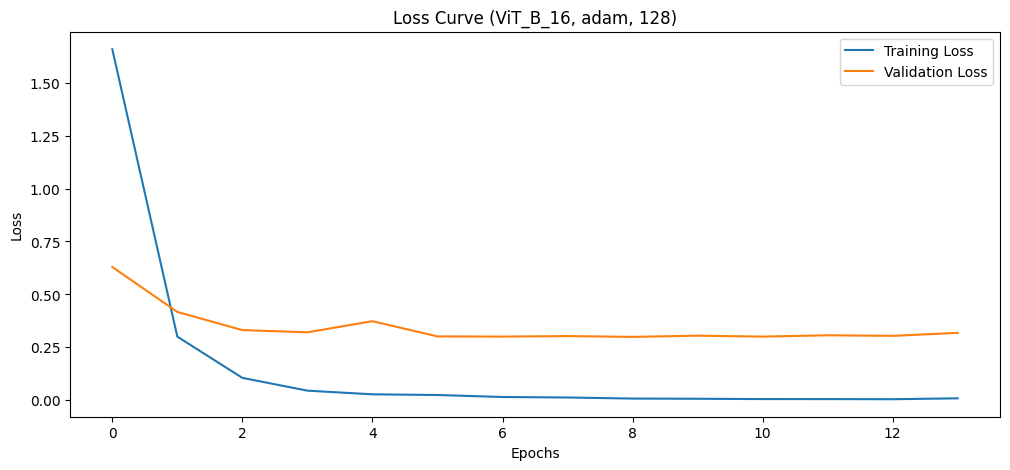

Testing: 100%|██████████| 41/41 [05:26<00:00,  7.97s/it]


Metrics appended to /content/drive/MyDrive/SHBT261/Project/outputs/vit_results/eval_results.json
Classification report saved to /content/drive/MyDrive/SHBT261/Project/outputs/vit_results/report_ViT_B_16_adam_128.csv
Confusion matrix saved to /content/drive/MyDrive/SHBT261/Project/outputs/vit_results/confusion_matrix_ViT_B_16_adam_128.png


In [12]:
# optimizer: adam, image_size: 128
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5,
                    model_name="ViT_B_16", optimizer_name="adam", img_size=128)
metrics = evaluate_model(model_path=f"{save_dir}/best_ViT_B_16_opt-adam_img-128.pth", model=model, test_loader=test_loader, lb=lb)

In [ ]:
# optimizer: adam, image_size: 64
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5,
                    model_name="ViT_B_16", optimizer_name="adam",img_size=64)
metrics = evaluate_model(model_path=f"{save_dir}/best_ViT_B_16_opt-adam_img-64.pth", model=model, test_loader=test_loader, lb=lb)